<a href="https://colab.research.google.com/github/Atharva2328/Q2-Datasets/blob/main/Atharva_C_Final_Q2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Atharva2328/Q2-Datasets.git


fatal: destination path 'Q2-Datasets' already exists and is not an empty directory.


In [5]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam


In [6]:
# Set path to cloned GitHub dataset
base_path = "Q2-Datasets/Q2/Geolife/Data"

# Model and data parameters
seq_len = 10
max_points = 2000


In [7]:
import glob
import os

base_path = "Q2-Datasets/Q2/Geolife/Data"
all_plt_files = glob.glob(os.path.join(base_path, "*", "Trajectory", "*.plt"))
print(f"Found {len(all_plt_files)} .plt files.")


Found 9999 .plt files.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 578s 6ms/step - loss: 5.3542e-04 - val_loss: 9.3324e-08
Epoch 2/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 606s 6ms/step - loss: 7.7982e-07 - val_loss: 2.4869e-08
Epoch 3/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 576s 6ms/step - loss: 5.4265e-07 - val_loss: 3.6065e-08
Epoch 4/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 589s 5ms/step - loss: 4.1677e-07 - val_loss: 1.1809e-07
Epoch 5/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 545s 5ms/step - loss: 4.2470e-07 - val_loss: 1.0756e-07
Epoch 6/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 520s 5ms/step - loss: 2.7012e-07 - val_loss: 7.4870e-08
Epoch 7/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 537s 5ms/step - loss: 2.9064e-07 - val_loss: 2.9861e-08
Epoch 8/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 560s 5ms/step - loss: 3.4975e-07 - val_loss: 3.8880e-08
Epoch 9/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 514s 5ms/step - loss: 2.5762e-07 - val_loss: 2.0252e-08
Epoch 10/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 539s 5ms/step - loss: 3.9045e-07 - val_loss: 1.2092e-08

42781/42781 ━━━━━━━━━━━━━━━━━━━━ 85s 2ms/step - loss: 3.0151e-08
Test MSE Loss: 4.8285922815693993e-08
42781/42781 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step


Text(0.5, 1.0, 'Trajectory Prediction - Test Set')

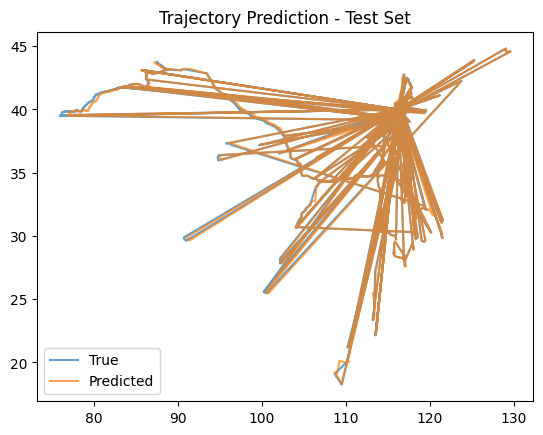

In [11]:
# PARAMETERS
base_path = "Q2-Datasets/Q2/Geolife/Data" # Dataset is stored
seq_len = 10 # Length of sequence
max_points = 2000 # Max number of data points to be consider
model_path = "geolife_lstm.h5" # Path to save trained model

# Loading plot files
def extract_lat_lon_from_plt(file_path, max_points=None): # Function to extract longitute and latitude
    try:
        df = pd.read_csv(file_path, skiprows=6, header=None) # Reading plot file
        df.columns = ["lat", "lon", "zero1", "altitude", "date_days", "date", "time"] # Assign column names
        coords = df[["lat", "lon"]].values # Extract latitude and longitude
        if max_points: # Limiting the number of data points
            coords = coords[:max_points] # Limiting data points
        return coords if len(coords) >= seq_len + 1 else None # Enough data points or sequence generation
    except:
        return None # Return if error reading file

def generate_sequences(coords, seq_len, scaler=None): # Function to generate sequence coordinates
    if scaler is None: # If no scaler create new
        scaler = MinMaxScaler() # Initialize minmaxscaler
        coords_scaled = scaler.fit_transform(coords) # Scale the coordinates (0-1)
    else:
        coords_scaled = scaler.transform(coords) # Use provided scaler

    X, y = [], [] # Initialize list to store inputs output
    for i in range(len(coords_scaled) - seq_len): # Loop to create sequence
        X.append(coords_scaled[i:i+seq_len]) # Making sequence length to 'x'
        y.append(coords_scaled[i+seq_len]) # Next point after sequence goes into 'y'
    return np.array(X), np.array(y) # Conve list into numpy array

# Loading Trajectory files
all_plt_files = glob.glob(os.path.join(base_path, "*", "Trajectory", "*.plt")) # Get path to all plot files
all_coords = [] # Hold coordinates from all files

for file in all_plt_files: # Loop through each file in list
    coords = extract_lat_lon_from_plt(file, max_points=max_points) # Extract coordinates from file
    if coords is not None: # Coordinates successfully extracted
        all_coords.append(coords) # Add them to list of coordinates

# Global Scaler Fit
flat_coords = np.vstack(all_coords) # Flatten all coordinates
scaler = MinMaxScaler() # Initialize mixmaxscaler
scaler.fit(flat_coords) # Fit scaler to entire set of coordinates

# Generate all Sequence
X_all, y_all = [], [] # Hold all input sequence(x) and corresponding outputs(y)
for coords in all_coords: # Loop through each coordinates
    X_seq, y_seq = generate_sequences(coords, seq_len, scaler) # Generate sequence
    X_all.append(X_seq) # Add input sequence to x
    y_all.append(y_seq) # Add corresponding outputs to y

X_all = np.vstack(X_all) # Keep all input sequence vertically
y_all = np.vstack(y_all) # Keep all output sequence vertically

# Splitting data 70% training, 15% Validation data, 15% test data
total = len(X_all) # Total number of sequence
train_end = int(0.7 * total) # 70% data for training
val_end = int(0.85 * total) # 15% for validation (70+15=85)

X_train, y_train = X_all[:train_end], y_all[:train_end] # Training data
X_val, y_val = X_all[train_end:val_end], y_all[train_end:val_end] # Validation data
X_test, y_test = X_all[val_end:], y_all[val_end:] # Test data

# Model Defination
model = Sequential([ # Starting neural network model
    LSTM(64, activation='relu', input_shape=(seq_len, 2)), # Adding LSTM layer with 64 units
    Dense(2) # Adding output layer with 2 units
])
model.compile(optimizer='adam', loss='mse') # Compiling model with optimizer

# Training
model.fit(
    X_train, y_train, # Training data
    epochs=20, # Train for 20 epochs
    batch_size=64, # Batch size of 64
    validation_data=(X_val, y_val) # Validate model on validation data
)

# Saving model
model.save(model_path) # Saving the model to specified path

# Analyse and Plot
loss = model.evaluate(X_test, y_test) # Analyse model on test data
print(f"Test MSE Loss: {loss}") # Print mean square error

# Predict and Plot
y_pred = model.predict(X_test) # Prediction on test data
y_pred_inv = scaler.inverse_transform(y_pred) # Inverse transform predictions to original scale
y_true_inv = scaler.inverse_transform(y_test) # Inverse transform test labels to original sccale

plt.plot(y_true_inv[:, 1], y_true_inv[:, 0], label='True', alpha=0.7) # Plot true latitude and longitude
plt.plot(y_pred_inv[:, 1], y_pred_inv[:, 0], label='Predicted', alpha=0.7) # Plot predicted latitude and longitude
plt.legend() # Shoe legend on plot
plt.title("Trajectory Prediction - Test Set") # Add title to plot

In [12]:
# RNN Model
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN # Import SimpleRNN along with other layers
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer

# ... (rest of your code) ...
def build_rnn_model(input_shape=(seq_len, 2)): # Function to build RNN model
    model = Sequential([ # Stacking layers
        SimpleRNN(64, activation='relu', input_shape=input_shape),  # Adding RNN layer with 64 units and ReLu activation
        Dense(2)  # Output layer
    ])
    model.compile(optimizer=Adam(), loss='mse') # Run model with optimizer and mean squared error loss
    return model # Return built model

# Building and training RNN model
rnn_model = build_rnn_model() # Building RNN model
rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val)) # Train and validate model

# Saving the RNN model
rnn_model.save('geolife_rnn_model.h5') # Saving trained RNN model to file


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 298s 3ms/step - loss: 0.0021 - val_loss: 1.9069e-07
Epoch 2/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 329s 3ms/step - loss: 6.6613e-07 - val_loss: 5.8314e-07
Epoch 3/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 297s 3ms/step - loss: 4.9891e-07 - val_loss: 5.0944e-08
Epoch 4/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 288s 3ms/step - loss: 3.6959e-07 - val_loss: 7.7833e-08
Epoch 5/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 287s 3ms/step - loss: 3.2273e-07 - val_loss: 7.6083e-07
Epoch 6/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 286s 3ms/step - loss: 3.7737e-07 - val_loss: 2.5532e-08
Epoch 7/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 334s 3ms/step - loss: 3.9926e-07 - val_loss: 1.2914e-08
Epoch 8/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 320s 3ms/step - loss: 3.4885e-07 - val_loss: 5.7554e-08
Epoch 9/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 317s 3ms/step - loss: 2.4880e-07 - val_loss: 1.4117e-08
Epoch 10/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 355s 3ms/step - loss: 3.8793e-07 - val_loss: 5.1381e-08
Epo

42781/42781 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 7.1361e-08
RNN Model Test MSE Loss: 1.922118002539719e-07
42781/42781 ━━━━━━━━━━━━━━━━━━━━ 51s 1ms/step
RMSE for latitude: 0.007815696921310412


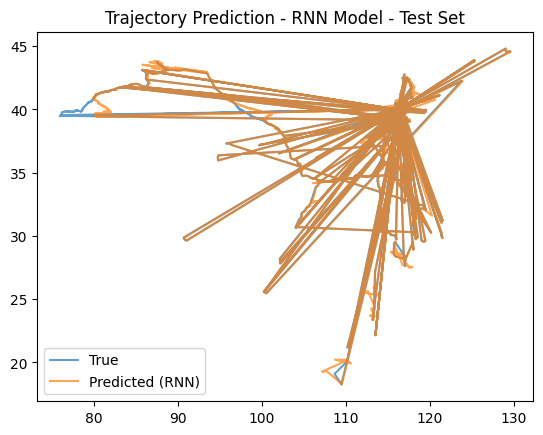

RMSE for latitude: 0.007815696921310412
RMSE for longitude: 0.14908572272217224


In [13]:
# Running RNN model
from sklearn.metrics import confusion_matrix # Predictions are correct or wrong
import seaborn as sns # Import seaborn and assign as sns
from sklearn.metrics import mean_squared_error
import numpy as np

rnn_loss = rnn_model.evaluate(X_test, y_test) # Run the trained model on test data
print(f"RNN Model Test MSE Loss: {rnn_loss}") # Calculate the mean squared error

# Predicting and plotting
y_pred_rnn = rnn_model.predict(X_test) # Predictions made on test data using trained RNN model
y_pred_rnn_inv = scaler.inverse_transform(y_pred_rnn) # Inverse transformed the predicted and test data to latitude and longitude

rmse = np.sqrt(mean_squared_error(y_true_inv[:, 0], y_pred_rnn_inv[:, 0]))
print(f"RMSE for latitude: {rmse}")

# Plotting the results for RNN
plt.plot(y_true_inv[:, 1], y_true_inv[:, 0], label='True', alpha=0.7) # Plot longitude and latitude
plt.plot(y_pred_rnn_inv[:, 1], y_pred_rnn_inv[:, 0], label='Predicted (RNN)', alpha=0.7) # Plot predicted trajectory
plt.legend() # Display legend
plt.title("Trajectory Prediction - RNN Model - Test Set") # Set title
plt.show() # Display plot

# Example: Calculate RMSE for latitude and longitude
rmse_lat = np.sqrt(mean_squared_error(y_true_inv[:, 0], y_pred_rnn_inv[:, 0]))
rmse_lon = np.sqrt(mean_squared_error(y_true_inv[:, 1], y_pred_rnn_inv[:, 1]))

print(f"RMSE for latitude: {rmse_lat}")
print(f"RMSE for longitude: {rmse_lon}")

In [14]:
# LSTM model
def build_lstm_model(input_shape=(seq_len, 2)): # LSTM model function
    model = Sequential([ # Stacking layers
        LSTM(64, activation='relu', input_shape=input_shape),  # LSTM layer with 64 unitsand ReLu activation
        Dense(2)  # Output Layer (Latitude, Longitude)
    ])
    model.compile(optimizer=Adam(), loss='mse') # Run model with optimizer and mean squared error loss
    return model # Return constructed model

# Building and training LSTM model
lstm_model = build_lstm_model() # Building model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val)) # Train LSTM on training data with 20 epochs
# Saving the LSTM model
lstm_model.save('geolife_lstm_model.h5') # Save the trained LSTM mdoel


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 572s 6ms/step - loss: 6.3715e-04 - val_loss: 3.0693e-06
Epoch 2/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 610s 6ms/step - loss: 1.0354e-06 - val_loss: 3.4261e-08
Epoch 3/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 617s 6ms/step - loss: 6.8429e-07 - val_loss: 5.5713e-08
Epoch 4/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 580s 6ms/step - loss: 3.9498e-07 - val_loss: 2.7369e-08
Epoch 5/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 619s 6ms/step - loss: 4.4987e-07 - val_loss: 1.7610e-07
Epoch 6/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 599s 6ms/step - loss: 5.1919e-07 - val_loss: 3.7578e-08
Epoch 7/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 595s 6ms/step - loss: 4.2368e-07 - val_loss: 3.8181e-08
Epoch 8/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 609s 6ms/step - loss: 3.1915e-07 - val_loss: 1.6477e-08
Epoch 9/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 565s 6ms/step - loss: 2.5780e-07 - val_loss: 1.3664e-08
Epoch 10/20
99822/99822 ━━━━━━━━━━━━━━━━━━━━ 579s 6ms/step - loss: 2.9385e-07 - val_loss: 1.6356e-08

42781/42781 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - loss: 4.7617e-08
LSTM Model Test MSE Loss: 6.182494871609379e-08
42781/42781 ━━━━━━━━━━━━━━━━━━━━ 75s 2ms/step


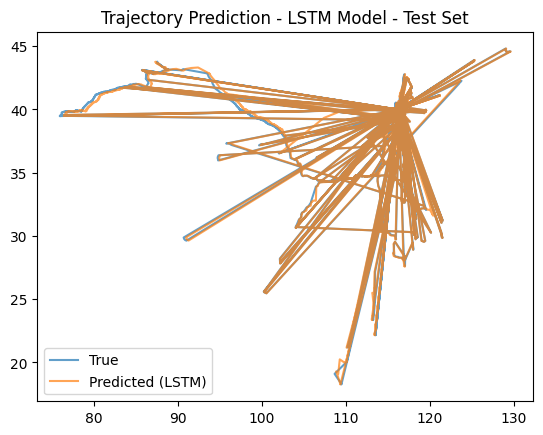

In [15]:
# Running LSTM model
lstm_loss = lstm_model.evaluate(X_test, y_test) # Run LSTM model on test data
print(f"LSTM Model Test MSE Loss: {lstm_loss}") # Display mean squared error loss

# Pridicting and Ploting using LSTM
y_pred_lstm = lstm_model.predict(X_test) # Predict output for test data
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm) # Inverse transform the predicted data and actual data
y_true_inv = scaler.inverse_transform(y_test)

# Plotting results for LSTM
plt.plot(y_true_inv[:, 1], y_true_inv[:, 0], label='True', alpha=0.7) # Plot longitude and latitude
plt.plot(y_pred_lstm_inv[:, 1], y_pred_lstm_inv[:, 0], label='Predicted (LSTM)', alpha=0.7) # Plot predicted trajectory
plt.legend() # Plot legend
plt.title("Trajectory Prediction - LSTM Model - Test Set") # Set title of plot
plt.show() # Display plot

# LSTM Confusion Matrix
# y_pred_lstm_classes = np.round(y_pred_lstm_inv) # Classify predicted values into categories
# conf_matrix_lstm = confusion_matrix(y_true_inv[:, 0], y_pred_lstm_inv[:, 0]) # Comparing predicted labels and true labels

# Displaying Confusin Matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues') # Add annotations to each cells
# plt.title('LSTM Confusion Matrix') # Set title
# plt.xlabel('Predicted Label') # Label x axis as predicted label
# plt.ylabel('True Label') # Label y axis as true label
#plt.show() # Display plot


In [16]:
# Generating CNN model Report
from sklearn.metrics import classification_report # Import classification_report
# Instead of classification_report, use regression metrics for continuous data
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print regression metrics for RNN
print("RNN Regression Report:")
print(f"Mean Squared Error: {mean_squared_error(y_true_inv, y_pred_rnn_inv)}")
print(f"R-squared: {r2_score(y_true_inv, y_pred_rnn_inv)}")

# Calculate and print regression metrics for LSTM
print("\nLSTM Regression Report:")
print(f"Mean Squared Error: {mean_squared_error(y_true_inv, y_pred_lstm_inv)}")
print(f"R-squared: {r2_score(y_true_inv, y_pred_lstm_inv)}")

RNN Regression Report:
Mean Squared Error: 0.011143818918978836
R-squared: 0.9990925936234889

LSTM Regression Report:
Mean Squared Error: 0.002246211375123015
R-squared: 0.9998141618847922
